In [1]:
# import pandas as pd
# import numpy as np
import collections

import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from ANP import *

import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import warnings
warnings.filterwarnings("ignore")

c:\Users\82109\anaconda3\envs\botorch_ex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds
print(dim)

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

20


In [3]:
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

### GP-EI

In [4]:
# # NUM_RESTARTS = 2
# # RAW_SAMPLES = 4
# # N_CANDIDATES = 4

# torch.manual_seed(0)

# X_ei = get_initial_points(dim, n_init)
# Y_ei = torch.tensor(
#     [eval_objective(x) for x in X_ei], dtype=dtype, device=device
# ).unsqueeze(-1)

# while len(Y_ei) < 400:
#     train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
#     likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
#     model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
#     mll = ExactMarginalLogLikelihood(model.likelihood, model)
#     fit_gpytorch_mll(mll)

#     # Create a batch
#     ei = qExpectedImprovement(model, train_Y.max())
#     candidate, acq_value = optimize_acqf(
#         ei,
#         bounds=torch.stack(
#             [
#                 torch.zeros(dim, dtype=dtype, device=device),
#                 torch.ones(dim, dtype=dtype, device=device),
#             ]
#         ),
#         q=batch_size,
#         num_restarts=NUM_RESTARTS,
#         raw_samples=RAW_SAMPLES,
#     )

#     Y_next = torch.tensor(
#         [eval_objective(x) for x in candidate], dtype=dtype, device=device
#     ).unsqueeze(-1)

#     # Append data
#     X_ei = torch.cat((X_ei, candidate), axis=0)
#     Y_ei = torch.cat((Y_ei, Y_next), axis=0)
#     # print(X_ei.size(), Y_ei.size())

#     # Print current status
#     print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

### NP-MC

In [5]:
import glob
import numpy as np
import torch
from math import pi
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class My_Ackley(Dataset):
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y

        # Generate data
        self.data = []
        self.data.append((self.train_x, self.train_y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [6]:
# ## bo
# from torch.utils.data import DataLoader
# from neural_process import NeuralProcess
# from training import NeuralProcessTrainer
# from botorch.sampling.normal import SobolQMCNormalSampler
# from utils import context_target_split
# from botorch.acquisition.monte_carlo import qExpectedImprovement
# from botorch.sampling.stochastic_samplers import StochasticSampler
# from botorch.acquisition.objective import IdentityMCObjective

# ## NP model
# x_dim = 20
# y_dim = 1
# r_dim = 50  # Dimension of representation of context points
# z_dim = 50  # Dimension of sampled latent variable
# h_dim = 50  # Dimension of hidden layers in encoder and decoder
# neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
# optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

# train_batch_size = 1
# num_context = 4
# num_target = 4
# np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
#                                   num_context_range=(num_context, num_context),
#                                   num_extra_target_range=(num_target, num_target), 
#                                   print_freq=200)

# torch.manual_seed(0)

# X_np = get_initial_points(dim, n_init)
# Y_np = torch.tensor(
#     [eval_objective(x) for x in X_np], dtype=dtype, device=device
# ).unsqueeze(-1)

# sampler = StochasticSampler(torch.Size([batch_size]), seed=1234)
# obj = IdentityMCObjective()

# while len(Y_np) < 400:
#     best_f = Y_np.max() 
#     train_Y = (Y_np - Y_np.mean()) / Y_np.std()
#     ackley_dataset = My_Ackley(train_x = X_np, train_y = train_Y)
#     data_loader = DataLoader(ackley_dataset, batch_size=train_batch_size, shuffle=True)

#     neuralprocess.training = True
#     np_trainer.train(data_loader, 200)

#     # Create a batch
#     neuralprocess.training = False
#     for batch in data_loader:
#         break
#     x, y = batch
#     x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
#                                                     num_context, 
#                                                     num_target)
#     neuralprocess.set_context_for_posterior(x_context, y_context)

#     ei = qExpectedImprovement(neuralprocess, best_f, sampler, obj)
#     candidate, acq_value = optimize_acqf(
#         ei,
#         bounds=torch.stack(
#             [
#                 torch.zeros(dim, dtype=dtype, device=device),
#                 torch.ones(dim, dtype=dtype, device=device),
#             ]
#         ),
#         q=batch_size, # The number of candidates
#         num_restarts=NUM_RESTARTS,
#         raw_samples=RAW_SAMPLES, # The number of samples for initialization.
#     )
#     # break
#     Y_next = torch.tensor(
#         [eval_objective(x) for x in candidate], dtype=dtype, device=device
#     ).unsqueeze(-1)

#     # Append data
#     X_np = torch.cat((X_np, candidate), axis=0)
#     Y_np = torch.cat((Y_np, Y_next), axis=0)

#     # Print current status
#     print(f"{len(X_np)}) Best value: {Y_np.max().item():.2e}")

In [7]:
# ## bo
# from torch.utils.data import DataLoader
# from neural_process import NeuralProcess
# from training import NeuralProcessTrainer
# from botorch.sampling.normal import SobolQMCNormalSampler
# from utils import context_target_split
# from botorch.acquisition.monte_carlo import qExpectedImprovement
# from botorch.sampling.stochastic_samplers import StochasticSampler
# from botorch.acquisition.objective import IdentityMCObjective

# ## NP model
# x_dim = 20
# y_dim = 1
# r_dim = 50  # Dimension of representation of context points
# z_dim = 50  # Dimension of sampled latent variable
# h_dim = 50  # Dimension of hidden layers in encoder and decoder
# neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
# optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

# train_batch_size = 1
# num_context = 4
# num_target = 4
# np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
#                                   num_context_range=(num_context, num_context),
#                                   num_extra_target_range=(num_target, num_target), 
#                                   print_freq=200)

# torch.manual_seed(0)

# X_np1 = get_initial_points(dim, n_init)
# Y_np1 = torch.tensor(
#     [eval_objective(x) for x in X_np1], dtype=dtype, device=device
# ).unsqueeze(-1)

# batch_size = 8

# sampler = StochasticSampler(torch.Size([batch_size]), seed=1234)
# obj = IdentityMCObjective()

# while len(Y_np1) < 400:
#     best_f = Y_np1.max() 
#     train_Y = (Y_np1 - Y_np1.mean()) / Y_np1.std()
#     ackley_dataset = My_Ackley(train_x = X_np1, train_y = train_Y)
#     data_loader = DataLoader(ackley_dataset, batch_size=train_batch_size, shuffle=True)

#     neuralprocess.training = True
#     np_trainer.train(data_loader, 200)

#     # Create a batch
#     neuralprocess.training = False
#     for batch in data_loader:
#         break
#     x, y = batch
#     x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
#                                                     num_context, 
#                                                     num_target)
#     neuralprocess.set_context_for_posterior(x_context, y_context)

#     ei = qExpectedImprovement(neuralprocess, best_f, sampler, obj)
#     candidate, acq_value = optimize_acqf(
#         ei,
#         bounds=torch.stack(
#             [
#                 torch.zeros(dim, dtype=dtype, device=device),
#                 torch.ones(dim, dtype=dtype, device=device),
#             ]
#         ),
#         q=batch_size, # The number of candidates
#         num_restarts=NUM_RESTARTS,
#         raw_samples=RAW_SAMPLES, # The number of samples for initialization.
#     )

#     Y_next = torch.tensor(
#         [eval_objective(x) for x in candidate], dtype=dtype, device=device
#     ).unsqueeze(-1)

#     # Append data
#     X_np1 = torch.cat((X_np1, candidate), axis=0)
#     Y_np1 = torch.cat((Y_np1, Y_next), axis=0)

#     # Print current status
#     print(f"{len(X_np1)}) Best value: {Y_np1.max().item():.2e}")

## TR-NP

In [8]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [9]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

In [11]:
## bo
from torch.utils.data import DataLoader
from neural_process import NeuralProcess
from training import NeuralProcessTrainer
from botorch.sampling.normal import SobolQMCNormalSampler
from utils import context_target_split
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.acquisition.objective import IdentityMCObjective

## NP model
x_dim = 20
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
##
neuralprocess.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
##
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

train_batch_size = 1
num_context = 4
num_target = 4
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

torch.manual_seed(0)

X_turbo_np = get_initial_points(dim, n_init)
Y_turbo_np = torch.tensor(
    [eval_objective(x) for x in X_turbo_np], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)

batch_size = 8

sampler = StochasticSampler(torch.Size([batch_size]), seed=1234)
obj = IdentityMCObjective()

torch.manual_seed(0)

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo_np - Y_turbo_np.mean()) / Y_turbo_np.std()

    ackley_dataset = My_Ackley(train_x = X_turbo_np, train_y = train_Y)
    data_loader = DataLoader(ackley_dataset, batch_size=train_batch_size, shuffle=True)

    neuralprocess.training = True
    np_trainer.train(data_loader, 200)

    # Create a batch
    neuralprocess.training = False
    for batch in data_loader:
        break
    x, y = batch
    x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                    num_context, 
                                                    num_target)
    neuralprocess.set_context_for_posterior(x_context, y_context)
    
    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        

        # Create a batch
        X_next = generate_batch(
            state=state,
            model=neuralprocess,
            X=X_turbo_np,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ei",
        )

    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo_np = torch.cat((X_turbo_np, X_next), dim=0)
    Y_turbo_np = torch.cat((Y_turbo_np, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo_np)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

iteration 200, loss 11.004


TypeError: len() of a 0-d tensor

## plot

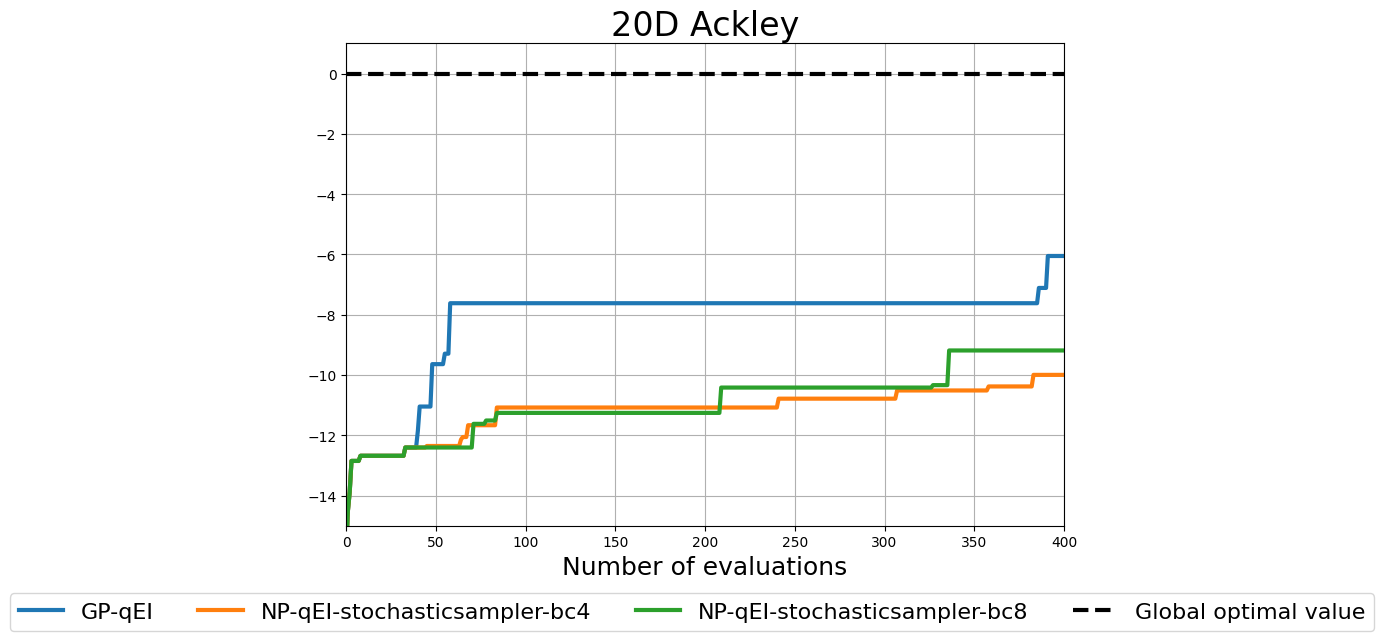

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

names = ["GP-qEI", "NP-qEI-stochasticsampler-bc4", "NP-qEI-stochasticsampler-bc8"] # , "EI", "Sobol"
runs = [Y_ei, Y_np, Y_np1] # , Y_ei, Y_Sobol
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_ei)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_ei)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()